In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
import amort_bnn
import gp_datasets
import tqdm.auto as tqdm
import np

torch.set_default_dtype(torch.float64)

/home/troch/venvs/amort-inf-bnn-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
gpdg = gp_datasets.GPDataGenerator()
num_tasks = 100
tasks = [gpdg.generate_task(range=[-3.0, 3.0]) for i in range(num_tasks)]

/home/troch/venvs/amort-inf-bnn-env/lib/python3.8/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(


### Construct and train the amortised BNN

Epoch: 100%|██████████| 1000/1000 [00:45<00:00, 21.79it/s, loss=tensor(17.6248, grad_fn=<NegBackward0>), ll=tensor(40.8679, grad_fn=<MeanBackward0>), kl=tensor(58.4926, grad_fn=<MeanBackward0>)]


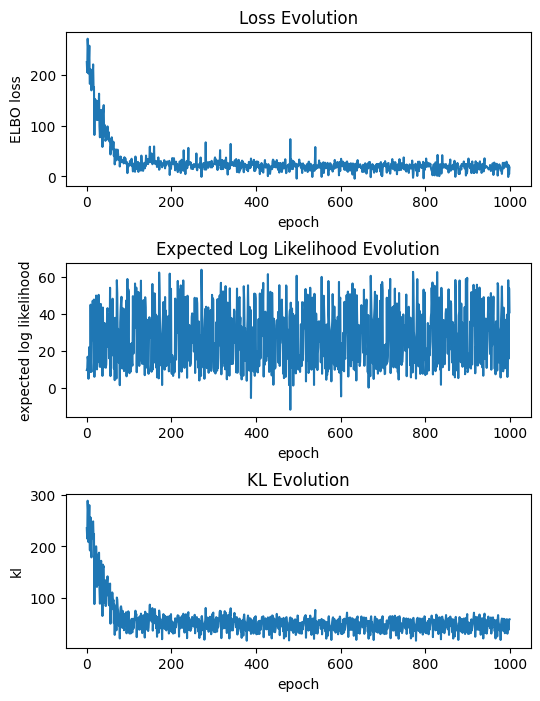

In [4]:
amort_bnn_model = amort_bnn.AmortNetwork(
    1,
    [50, 50],
    1,
)

opt = torch.optim.Adam(amort_bnn_model.parameters(), lr=1e-2)

loss_evo = []
ll_evo = []
kl_evo = []

epoch_iter = tqdm.tqdm(range(1000), "Epoch")
for i, epoch in enumerate(epoch_iter):
    
    task = tasks[i%num_tasks]
    
    opt.zero_grad()

    loss, ll, kl, noise = amort_bnn_model.elbo_loss(
        task['x_context'].unsqueeze(1), task['y_context'].unsqueeze(1), num_samples=1
    )
    loss_evo.append(loss.item())
    ll_evo.append(ll.item())
    kl_evo.append(kl.item())

    loss.backward()
    opt.step()
    
    epoch_iter.set_postfix({"loss": loss, "ll": ll, "kl": kl})
    
fig, axs = plt.subplots(3, 1)
fig.set_size_inches(6, 8)
fig.subplots_adjust(hspace=0.5)

axs[0].plot(loss_evo)
axs[0].set_ylabel("ELBO loss")
axs[0].set_xlabel("epoch")
axs[0].set_title("Loss Evolution")

axs[1].plot(ll_evo)
axs[1].set_ylabel("expected log likelihood")
axs[1].set_xlabel("epoch")
axs[1].set_title("Expected Log Likelihood Evolution")

axs[2].plot(kl_evo)
axs[2].set_ylabel("kl")
axs[2].set_xlabel("epoch")
axs[2].set_title("KL Evolution")

plt.show()

### Construct and train a Gaussian conditional neural process

Epoch: 100%|██████████| 1000/1000 [00:09<00:00, 108.02it/s, loss=tensor(20.7359, grad_fn=<NegBackward0>)]


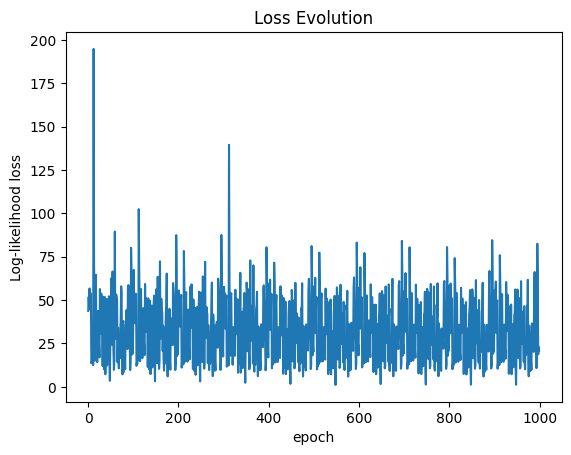

In [5]:
gcnp = np.GCNP( 
    data_dim = 1,
    enc_hidden_dims = [50, 50],
    representation_dim = 50,
    dec_hidden_dims = [50, 50],
)

opt = torch.optim.Adam(gcnp.parameters(), lr=1e-2)

loss_evo = []

epoch_iter = tqdm.tqdm(range(1000), "Epoch")
for i, epoch in enumerate(epoch_iter):
    
    task = tasks[i%num_tasks]
    
    opt.zero_grad()

    loss = gcnp.neg_ll(
        task['x_context'].unsqueeze(1),
        task['y_context'].unsqueeze(1),
        task['x_target'].unsqueeze(1),
        task['y_target'].unsqueeze(1),
    )
    loss_evo.append(loss.item())

    loss.backward()
    opt.step()
    
    epoch_iter.set_postfix({"loss": loss})

plt.plot(loss_evo)
plt.ylabel("Log-likelihood loss")
plt.xlabel("epoch")
plt.title("Loss Evolution")

plt.show()

### Generate predictions for each model

In [6]:
xs = torch.linspace(-2.5, 2.5, 100).unsqueeze(1)
test_task = gpdg.generate_task(range=[-2.0, 2.0])

amort_prediction_samps = amort_bnn_model(
    test_task['x_context'].unsqueeze(1),
    test_task['y_context'].unsqueeze(1),
    x_test=xs,
    num_samples=100)[1].squeeze(-1).T

np_mu, np_logstd = gcnp(
    test_task['x_context'].unsqueeze(1),
    test_task['y_context'].unsqueeze(1),
    xs,
)

### Plot predictions for each model

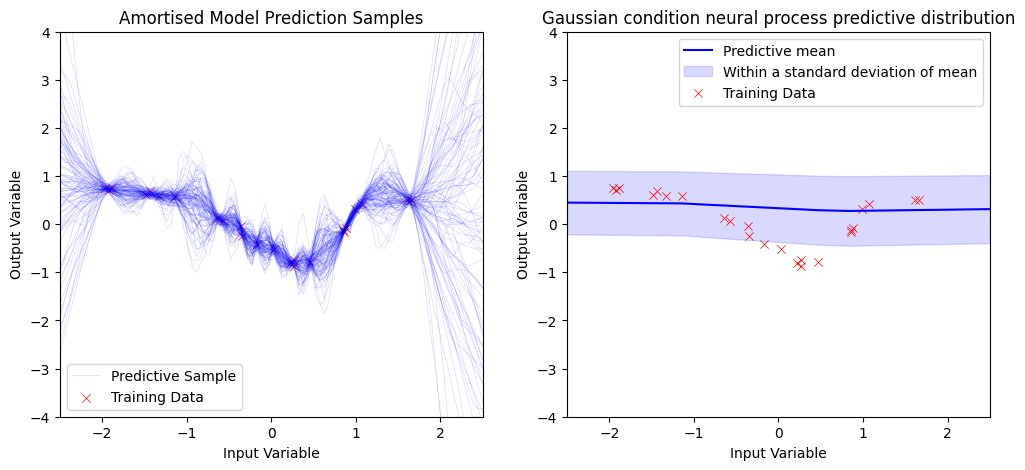

In [7]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

axs[0].plot(
    xs,
    amort_prediction_samps.detach().numpy()[:, :-1],
    color="blue",
    linewidth=0.5,
    alpha=0.15,
)
axs[0].plot(
    xs,
    amort_prediction_samps.detach().numpy()[:, -1],
    color="blue",
    linewidth=0.5,
    alpha=0.15,
    label="Predictive Sample",
)
axs[0].set_title("Amortised Model Prediction Samples")
axs[0].set_xlabel("Input Variable")
axs[0].set_ylabel("Output Variable")
axs[0].scatter(test_task['x_context'], test_task['y_context'], marker="x", label="Training Data", color='red', linewidth=0.5)
    
axs[0].legend()
axs[0].set_ylim(-4.0, 4.0)
axs[0].set_xlim(-2.5, 2.5)

axs[1].plot(
    xs.squeeze(),
    np_mu.detach().squeeze(),
    color='blue',
    label='Predictive mean',
)

axs[1].fill_between(
    xs.squeeze(),
    (np_mu.detach() + np_logstd.detach().exp()).squeeze(),
    (np_mu.detach() - np_logstd.detach().exp()).squeeze(),
    color="blue",
    label='Within a standard deviation of mean',
    alpha=0.15,
)
axs[1].set_title("Gaussian condition neural process predictive distribution")
axs[1].set_xlabel("Input Variable")
axs[1].set_ylabel("Output Variable")
axs[1].scatter(test_task['x_context'], test_task['y_context'], marker="x", label="Training Data", color='red', linewidth=0.5)
    
axs[1].legend()
axs[1].set_ylim(-4.0, 4.0)
axs[1].set_xlim(-2.5, 2.5)

plt.show()